In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Part 1: For each indices we calibrate the model's parameters an draw mean levels against market caps

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')
# Create the Scaler object
#scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
#df_cap = pd.DataFrame(scaler.fit_transform(df_cap))
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates
df_cap.set_index('date',inplace=True)

# get stock indices
stock_id=df_cap.iloc[0,:].index



df_cap.head()

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Perform Parameter's calibration

Assume $q_t = log X_t$ and apply Ito's lemma:

$$
\Delta q_t = \kappa_x \cdot \left( Wz^{'}_{t} - \frac{1}{2} \frac{\sigma^2}{\kappa_x} - x_t\right) \Delta t + \sigma \cdot \Delta W_t
$$

The problem reduces to find that set of parameters so that, 


$$  
\underset{\Theta}{Arg Min}  \; \sum_{t=0}^{T-1} \left| \Sigma_x \right|  +  \left( {\bf v}_t \right)^{T}  \Sigma_x^{-1}   {\bf v}_t + \lambda (w1 + w2 - 1)^2
$$


where

$$  
{\bf v}_t \equiv log \frac{{\bf x}_{t+1} }{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t' - \frac{1}{2} \frac{\sigma^2}{\kappa_x}  - {\bf x}_t \right)  
$$



In [3]:
# likelihood function definition
def mle(params,X,Z1,Z2,asset_id):
    kappa = params[0]
    sigma = params[1]
    correl = 0.0

    w0 = params[2]
    w1 = params[3]
    w2 = params[4]
    X_t = np.array(X.iloc[0:-1,:])    
    Z1 = np.array(Z1.iloc[:-1, :])
    Z2 = np.array(Z2.iloc[:-1, :])

   
    log_returns_X = np.array(np.log(1 + X.pct_change()).iloc[1:, :]) # removed first NaN




    nb_assets = log_returns_X.shape[1]
    sample_size = log_returns_X.shape[0]

        
    # WZ
    Wz = w0 + w1 * Z1 + w2 * Z2
 
    # VCV Matrix inverse ...
    Sigma = np.eye(log_returns_X.shape[1]) * (sigma ** (2))


        # Calculate v_t
    v_t = log_returns_X - kappa * (Wz - 0.5 * sigma**2/kappa - X_t)
###################
    v_t=v_t[:,asset_id]
    nb_assets=1
####################
#print(np.dot(v_t[0], v_t[0]))    
        # Calculate v'v/sigma^2 (Valid as long as we define VCV to be diagonal => independence)                
    quadratic_term = 0
    for i in range(sample_size):            
            #density *= multivariate_normal.pdf(self.log_returns_X[i], mu_t[i], Sigma)
        quadratic_term += np.dot(v_t[i], v_t[i])
    quadratic_term /= (sigma**2)
   


        # Calculate objective function Sum |Sigma| + v'v/sigma^2
    objective_funct_val = quadratic_term + sample_size * ( nb_assets) * np.log(sigma)

        # Calculate penalty function
    penalty_coef =  10e-2;
    penalty_function =  penalty_coef * (w1 + w2 - 1)**2
    return objective_funct_val + penalty_function

In [4]:
def print_estimated_mean_rate(date_from, date_to, asset_id, parameters):

    # Retrieve market signals ...
    Z1_array = np.array(Z1.loc[date_from:date_to, asset_id])
    Z2_array = np.array(Z2.loc[date_from:date_to, asset_id])

    # Retrieve dates and mkt and model caps ..
    dates = np.array(X.loc[date_from:date_to, :].index)
    X_t_model = np.array(X.loc[date_from:date_to, asset_id])
    X_t_mket = np.array(X.loc[date_from:date_to, asset_id])

    
    kappa = parameters[0]
    sigma = parameters[1]
    w0 = parameters[2]
    w1 = parameters[3]
    w2 = parameters[4]
    
    # -> Calculate Wz
    Wz = w0 + w1 * Z1_array + w2 * Z2_array

    # lon run mean level 
    theta_z = Wz - 0.5 * sigma**2 / kappa
 
    


    # GRAPH ...
    fig = plt.figure(figsize=(15,6))

    # Print theta z
    ax = fig.add_subplot(1,2,1)
    ax.plot( theta_z, label = 'Theta')
    ax.legend(loc='best')
    ax.set_title('Mean rate')

    # print market caps ...
    ax = fig.add_subplot(1,2,2)
    ax.plot( X_t_mket, label = 'Mkt cap ')
    ax.plot( theta_z, label = 'Mean rate')
    ax.legend(loc='best')
    ax.set_title('Normalized capiltalization')


    plt.show()


Example of calibration and check for 'AXP'  stock

      fun: -1406.4563541479683
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0347427 , -0.04615686,  1.60034688,  0.62620984, -0.80319751])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 570
      nit: 62
   status: 0
  success: True
        x: array([4.0156735 , 0.02373729, 0.0042492 , 0.25963029, 0.41657371])


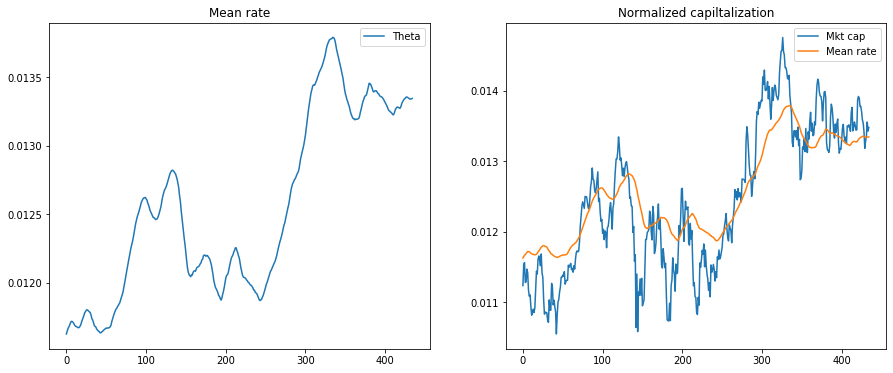

In [5]:


date_from = '2011-01-01'
date_to = '2012-09-01' 


# start data analisis and signal extraction

X = df_cap.loc[:,:]
X_mean = X.mean(axis = 0).sum() 
X /= X_mean 

window_1 = 15  
window_2 = 30
         # Equal weighted
Z1 = X.rolling(window=window_1).mean()
Z2 = X.rolling(window=window_2).mean()

# remove NaN
X = X.iloc[window_2:,:]
Z1 = Z1.iloc[window_2:,:]
Z2 = Z2.iloc[window_2:,:]
X_window = X.loc[date_from:date_to, :]
Z1_window = Z1.loc[date_from:date_to, :]
Z2_window = Z2.loc[date_from:date_to, :]

params=[0.2,0.2,0.2,0.2,0.2]
lb = np.array([-10, 0.0001, -5, 0.0001, 0.0001])
ub = np.array([10,   5,     5, 1,      1])
bounds = [(lb[0], ub[0]), (lb[1], ub[1]), (lb[2], ub[2]), (lb[3], ub[3]), (lb[4], ub[4])]
# PERFORM CALIBRATION
asset_id = 1 # 1 corresponds to 'AXP'
res = minimize(mle,params,args=(X_window,Z1_window,Z2_window,asset_id,),bounds = bounds,
                       method='L-BFGS-B', options={'gtol': 1e-10, 'disp': True}, tol = 1e-9)
print(res)

# check 
print_estimated_mean_rate(date_from, date_to, 'AXP', res.x)

calibration of the parameters for all the stock

In [6]:
dfObj = pd.DataFrame(columns=['k', 'sigma', 'W0','W1','W2'],index=stock_id)
for asset_id in range(0,30):
    res = minimize(mle,params,args=(X_window,Z1_window,Z2_window,asset_id,),bounds = bounds,
                       method='L-BFGS-B', options={'gtol': 1e-10, 'disp': True}, tol = 1e-9)

# Append rows in Empty Dataframe by adding dictionaries
    dfObj.loc[stock_id[asset_id]]=[res.x[0],res.x[1],res.x[2],res.x[3],res.x[4]]
 
#print("Dataframe Contens ", dfObj, sep='\n')
dfObj

,k,sigma,W0,W1,W2
AAPL,0.00166082,0.0236604,1.12071,0.485152,0.46888
AXP,4.01567,0.0237373,0.0042492,0.25963,0.416574
BA,0.00536093,0.0236374,0.0722,0.209568,0.209567
CAT,0.00513392,0.0299842,0.0687755,0.195706,0.195705
CSCO,0.00203485,0.028783,0.0710477,0.195578,0.195577
CVX,1.04114,0.0211728,0.0411794,0.0129973,0.0409797
DIS,0.611877,0.0237329,0.00933439,0.246501,0.246648
DWDP,0.00225774,0.0329796,0.0667608,0.195759,0.195758
GE,0.311892,0.0232337,0.0263273,0.21136,0.211612
GS,-0.000755586,0.0313648,0.689477,0.506246,0.506815


## Part 2: same as part I but with EWMA as a signal

      fun: -1405.7113470697877
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.09412213e-01, -6.46070930e+00, -6.48609512e+02, -8.04097908e+00,
       -7.65289769e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 432
      nit: 40
   status: 0
  success: True
        x: array([4.61947079e+00, 2.37716439e-02, 4.39381744e-03, 3.30106769e-01,
       3.27418661e-01])


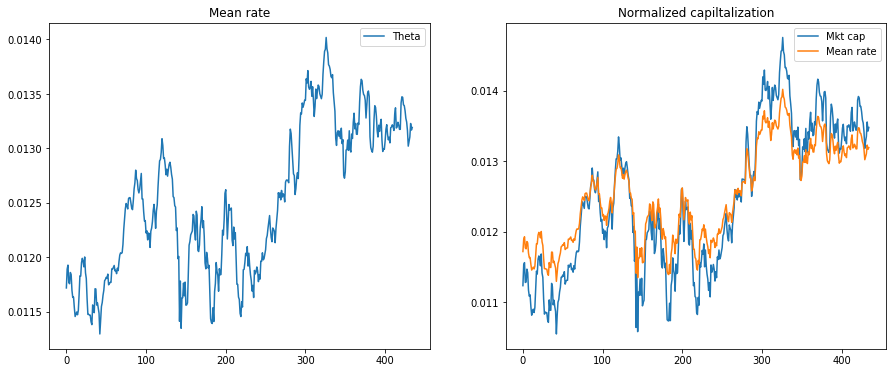

In [7]:
Z1 = X.ewm(alpha = 0.8, adjust = True).mean()
Z2 = X.ewm(alpha = 0.96, adjust = True).mean()
# remove NaN
X = X.iloc[window_2:,:]
Z1 = Z1.iloc[window_2:,:]
Z2 = Z2.iloc[window_2:,:]
date_from = '2011-01-01'
date_to = '2012-09-01' 

#-> Retrieve X, Z1 and Z2 only for the estimation window ...
X_window = X.loc[date_from:date_to, :]
Z1_window = Z1.loc[date_from:date_to, :]
Z2_window = Z2.loc[date_from:date_to, :]

params=[0.2,0.2,0.2,0.2,0.2]
lb = np.array([-0.01, 0.001, -5, 0.0001, 0.0001])
ub = np.array([5,   0.5,     5, 1,      1])
bounds = [(lb[0], ub[0]), (lb[1], ub[1]), (lb[2], ub[2]), (lb[3], ub[3]), (lb[4], ub[4])]
# PERFORM CALIBRATION
asset_id=1
res = minimize(mle,params,args=(X_window,Z1_window,Z2_window,asset_id,),bounds = bounds,
                       method='L-BFGS-B', options={'gtol': 1e-10, 'disp': True}, tol = 1e-9)
print(res)

print_estimated_mean_rate(date_from, date_to, 'AXP', res.x)

In [8]:
dfObj = pd.DataFrame(columns=['k', 'sigma', 'W0','W1','W2'],index=stock_id)
for asset_id in range(0,30):
    res = minimize(mle,params,args=(X_window,Z1_window,Z2_window,asset_id,),bounds = bounds,
                       method='L-BFGS-B', options={'gtol': 1e-10, 'disp': True}, tol = 1e-9)

# Append rows in Empty Dataframe by adding dictionaries
    dfObj.loc[stock_id[asset_id]]=[res.x[0],res.x[1],res.x[2],res.x[3],res.x[4]]
 
#print("Dataframe Contens ", dfObj, sep='\n')
dfObj

,k,sigma,W0,W1,W2
AAPL,0.00143679,0.0236609,1.29034,0.485222,0.48601
AXP,4.61947,0.0237716,0.00439382,0.330107,0.327419
BA,4.66255,0.0234621,0.0067481,0.196861,0.194858
CAT,3.44223,0.0298647,0.00517428,0.303641,0.303204
CSCO,5,0.0285608,0.00509548,0.370839,0.375282
CVX,1.15348,0.0211732,0.0377879,0.0657509,0.0655904
DIS,5,0.0236044,0.00118845,0.934754,0.0001
DWDP,5,0.0328552,0.00333994,0.294003,0.286354
GE,0.320792,0.0232328,0.0287377,0.181008,0.180166
GS,5,0.0312313,0.00159953,0.863097,0.0001


## Part III

calibration of the parameters for S&P500:
now we minimize the likelihood for all the stocks together

In [9]:
# likelihood function definition
def mleMarket(params,X,Z1,Z2):
    kappa = params[0]
    sigma = params[1]
    correl = 0.0

    w0 = params[2]
    w1 = params[3]
    w2 = params[4]
    X_t = np.array(X.iloc[0:-1,:])    
    Z1 = np.array(Z1.iloc[:-1, :])
    Z2 = np.array(Z2.iloc[:-1, :])

   
    log_returns_X = np.array(np.log(1 + X.pct_change()).iloc[1:, :]) # removed first NaN




    nb_assets = log_returns_X.shape[1]
    sample_size = log_returns_X.shape[0]

        
    # WZ
    Wz = w0 + w1 * Z1 + w2 * Z2
 
    # VCV Matrix inverse ...
    Sigma = np.eye(log_returns_X.shape[1]) * (sigma ** (2))


        # Calculate v_t
    v_t = log_returns_X - kappa * (Wz - 0.5 * sigma**2/kappa - X_t)
###################

####################
#print(np.dot(v_t[0], v_t[0]))    
        # Calculate v'v/sigma^2 (Valid as long as we define VCV to be diagonal => independence)                
    quadratic_term = 0
    for i in range(sample_size):            
            #density *= multivariate_normal.pdf(self.log_returns_X[i], mu_t[i], Sigma)
        quadratic_term += np.dot(v_t[i], v_t[i])
    quadratic_term /= (sigma**2)
   


        # Calculate objective function Sum |Sigma| + v'v/sigma^2
    objective_funct_val = quadratic_term + sample_size * ( nb_assets) * np.log(sigma)

        # Calculate penalty function
    penalty_coef =  10e-2;
    penalty_function =  penalty_coef * (w1 + w2 - 1)**2
    return objective_funct_val + penalty_function

In [10]:
# Put the # EUROSTOXX
df_cap = pd.read_csv('spx_holdings_and_spx_closeprice.csv')

dates = df_cap.iloc[:,0]

df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap = df_cap.drop(df_cap.columns[[0]], axis=1)  # df.columns is zero-based pd.Index 
df_cap.index

# DROP NaN ...
df_cap = df_cap.dropna()

# start data analisis and signal extraction

X = df_cap.loc[:,:]
X_mean = X.mean(axis = 0).sum() 
X /= X_mean 

window_1 = 15  
window_2 = 30
         # Equal weighted
Z1 = X.rolling(window=window_1).mean()
Z2 = X.rolling(window=window_2).mean()

# remove NaN
X = X.iloc[window_2:,:]
Z1 = Z1.iloc[window_2:,:]
Z2 = Z2.iloc[window_2:,:]

date_from = '2011-01-01'
date_to = '2012-09-01' 

#-> Retrieve X, Z1 and Z2 only for the estimation window ...
X_window = X.loc[date_from:date_to, :]
Z1_window = Z1.loc[date_from:date_to, :]
Z2_window = Z2.loc[date_from:date_to, :]

params=[0.2,0.2,0.2,0.2,0.2]
lb = np.array([-0.01, 0.001, -5, 0.0001, 0.0001])
ub = np.array([5,   0.5,     5, 1,      1])
bounds = [(lb[0], ub[0]), (lb[1], ub[1]), (lb[2], ub[2]), (lb[3], ub[3]), (lb[4], ub[4])]
# PERFORM CALIBRATION
asset_id=1
res = minimize(mleMarket,params,args=(X_window,Z1_window,Z2_window,),bounds = bounds,
                       method='L-BFGS-B', options={'gtol': 1e-10, 'disp': True}, tol = 1e-9)
print(res)
# Creating an empty Dataframe with column names only
dfObj = pd.DataFrame(columns=['k', 'sigma', 'W0','W1','W2'],index=['S&P500'])
# Append rows in Empty Dataframe by adding dictionaries
dfObj.loc['S&P500']=[res.x[0],res.x[1],res.x[2],res.x[3],res.x[4]]
 
#print("Dataframe Contens ", dfObj, sep='\n')
dfObj

      fun: -532287.231423773
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.25962901, 35.01772881, -1.93249434, -1.68802217, -2.0256266 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 40
   status: 0
  success: True
        x: array([0.02308758, 0.02946063, 0.02098286, 0.25364206, 0.25379852])


,k,sigma,W0,W1,W2
S&P500,0.0230876,0.0294606,0.0209829,0.253642,0.253799
